In [ ]:
import numpy as np
import sympy as sp

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, Lambda, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.losses import BinaryCrossentropy            #Función de costo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

##CAMBIAR .RAR A .ZIP

In [ ]:
#carpeta de imágenes
!unzip Facemask.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
import sys
import cv2
import glob
import numpy as np
import pickle as cPickle
import time
import random
import scipy.cluster.vq as vq
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def prepareFiles(rootpath):
	current_GT_id=0
	filenames=[]
	GT_ids=[]
	GT_labels=[]
	classpath = sorted(glob.glob(rootpath+'*'))
	for i in classpath:
		filespath = sorted(glob.glob(i+'/*.png'))
		for j in filespath:
			filenames.append(j)
			GT_ids.append(current_GT_id)
			GT_labels.append(i.split('/')[-1])
		current_GT_id+=1
	return(filenames,GT_ids,GT_labels)

In [ ]:
# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_train='./Facemask/Train/'

# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_valid='./Facemask/Validation/'

# Directorio raiz donde se encuentran todas las imágenes de test
dataset_folder_test='./Facemask/Test/'

In [ ]:
# Separación de train, valid, test
# Cálculo de puntos de interés para todas las imágenes del conjunto de aprendizaje
filenames_train,GT_ids_train,GT_labels_train = prepareFiles(dataset_folder_train)
filenames_valid,GT_ids_valid,GT_labels_valid = prepareFiles(dataset_folder_valid)
filenames_test,GT_ids_test,GT_labels_test = prepareFiles(dataset_folder_test)


#filenames_train: contiene todas las imágenes de train
#GT_ids_train: contiene las clases a la que pertenecen cada imagen
#GT_labels_train: son las etiquetas de cada clase de imágen

In [ ]:
filenames_train = filenames_train[0:800]+filenames_train[9199:9999]
GT_ids_train = GT_ids_train[0:800]+GT_ids_train[9199:9999]

#Valid: Usando solo 400 imágenes: 200 de with y 200 de without
filenames_valid = filenames_valid[0:200]+filenames_valid[599:799]
GT_ids_valid = GT_ids_valid[0:200]+GT_ids_valid[599:799]

In [ ]:
def getKeypointsDescriptors(filenames):
  A=[]
  print('Obtaining the images matrix from the filenames')
  init=time.time()
  for filename in filenames:
    ima=cv2.imread(filename)
    #ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    ima = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    dim = (256, 256)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA)
    A.append(ima)
  end=time.time()
  print('Done in '+str(end-init)+' secs.')
  return(A)

In [ ]:
#Train:
X_train = getKeypointsDescriptors(filenames_train)
y_train = GT_ids_train 

#Validation:
X_valid = getKeypointsDescriptors(filenames_valid)
y_valid = GT_ids_valid 

#Test:
X_test = getKeypointsDescriptors(filenames_test)
y_test = GT_ids_test

Obtaining the images matrix from the filenames
Done in 0.9726850986480713 secs.
Obtaining the images matrix from the filenames
Done in 0.3599252700805664 secs.
Obtaining the images matrix from the filenames
Done in 0.9889552593231201 secs.


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
import numpy as np
np.unique(y_train)

#Clasificador binario -> No es necesario one hot encoder

array([0, 1])

In [ ]:
# Tamaños (With and Without mask)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Número de datos de entrenamiento y de prueba
ntrain = X_train.shape[0]
nvalid = X_valid.shape[0]
ntest = X_test.shape[0]

# Tamaño de la imagen
npx = X_train.shape[1] 

Tamaño del conjunto de entrenamiento: (1600, 256, 256)
Tamaño del conjunto de validación: (400, 256, 256)
Tamaño del conjunto de prueba: (992, 256, 256)


In [ ]:
#Dado que los labels de la data están basados en números, genero este vector para poder facilitar visualmente
class_names = ['Wearing mask', 'No wearing mask']

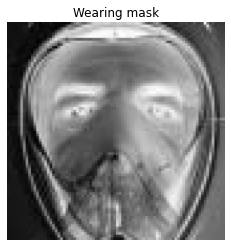

In [ ]:
#mostrar imagen
idx = 0
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()


    # ima = np.resize(ima, (153, 153))
    # ima = np.reshape(ima, (164, 123))

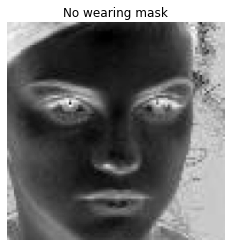

In [ ]:
#mostrar imagen
idx = 1200
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

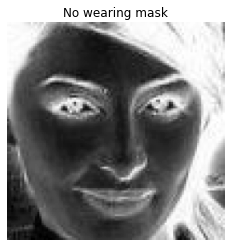

In [ ]:
#mostrar imagen
idx = 1555
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

##Pre-procesamiento

In [ ]:
# Aumentar 1 dimension para que esté en formato que acepta Keras (escala a grises)
X_train = X_train.reshape(ntrain, npx, npx, 1) 
X_valid = X_valid.reshape(nvalid, npx, npx, 1)
X_test = X_test.reshape(ntest, npx, npx, 1)   

print("Tamaño modificado del conjunto de entrenamiento:", X_train.shape)
print("Tamaño modificado del conjunto de validacion:", X_valid.shape)
print("Tamaño modificado del conjunto de prueba:", X_test.shape)

Tamaño modificado del conjunto de entrenamiento: (1600, 256, 256, 1)
Tamaño modificado del conjunto de validacion: (400, 256, 256, 1)
Tamaño modificado del conjunto de prueba: (992, 256, 256, 1)


In [ ]:
#Normalizando
X_train = X_train/255.        #el . es para que sea float
X_valid = X_valid/255.
X_test = X_test/255.

##Creando nuestra CNN

In [ ]:
#import tensorflow as tf
#import matplotlib.pyplot as plt
#from tensorflow.keras import datasets, layers, models, losses
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape=(256, 256, 1), classes=1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (256, 256, 1), classes = 1)

In [ ]:
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'       #para almacenar cada mejor modelo encontrado con con cada iteracion

cp = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True,
                     mode='min')
#el checkpoint(cp) guardará los parámetros del modelo que generen el mínimo de 'val_loss' y se quedará con esos hasta que aparezca un menor a loss

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   mode='min',
                   verbose=0,
                   restore_best_weights=True)
# si "es" detecta 10 veces seguidas que el 'val_loss' está subiendo(malo) entonces parará las iteraciones

pl = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=5,
                       verbose=0,
                       mode='min')


model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])


In [ ]:
X_train.shape, X_valid.shape

((1600, 256, 256, 1), (400, 256, 256, 1))

In [ ]:
history = model.fit(x=X_train,
          y=y_train,
          batch_size=10,
          epochs=25,
          validation_data=(X_valid, y_valid),
          shuffle=True,
          verbose=True,
          callbacks=[cp, es, pl]
         )

Epoch 1/25
160/160 [==============================] - ETA: 0s - loss: 2.8739 - accuracy: 0.6369
Epoch 00001: val_loss improved from inf to 11.30795, saving model to ./my_best_model.epoch01-loss11.31.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


160/160 [==============================] - 1487s 9s/step - loss: 2.8739 - accuracy: 0.6369 - val_loss: 11.3079 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 2/25
160/160 [==============================] - ETA: 0s - loss: 1.2982 - accuracy: 0.7081
Epoch 00002: val_loss improved from 11.30795 to 1.53517, saving model to ./my_best_model.epoch02-loss1.54.hdf5
160/160 [==============================] - 1485s 9s/step - loss: 1.2982 - accuracy: 0.7081 - val_loss: 1.5352 - val_accuracy: 0.5275 - lr: 0.0010
Epoch 3/25
160/160 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8938
Epoch 00003: val_loss did not improve from 1.53517
160/160 [==============================] - 1487s 9s/step - loss: 0.3610 - accuracy: 0.8938 - val_loss: 2.2444 - val_accuracy: 0.5575 - lr: 0.0010
Epoch 4/25
108/160 [===================>..........] - ETA: 7:31 - loss: 0.6782 - accuracy: 0.8611

In [ ]:
model.summary()

#Ploteo

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)

In [ ]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[1]))
print ("Test Accuracy = " + str(preds[1]))